In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import joblib
from PIL import Image
import json
import csv
from app import get_altum_age, get_hannum_age, get_horvath_age, get_pheno_age, get_grim_age, get_horvath_sb_age

In [8]:
organs = ['Blood', 'Breast', 'Colon', 'Kidney', 'Lung', 'Muscle', 'Ovary', 'Prostate', 'Testis', 'Infant']
with open('clocks/21K_cpgs.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        cpgs_21k = row

with open('clocks/900_cpgs.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        cpgs_900 = row

with open('clocks/470_cpgs.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        cpgs_470 = row

In [9]:
gtex_train_X = pd.DataFrame(np.load('GTEX_trainX.npy'), columns=cpgs_21k)
gtex_train_Y = np.load('GTEX_trainY.npy')
with open('GTEX_test.json', 'r') as file:
    gtex_test = json.load(file)
    for key, val in gtex_test.items():
        gtex_test[key] = (pd.DataFrame(np.array(val[0]), columns=cpgs_21k), np.array(val[1]))

In [10]:
infant_data_missing_cpgs = ['cg02654291', 'cg02972551', 'cg04431054', 'cg05590257', 'cg06007645', 'cg06117855', 'cg07927379', 'cg09651136', 'cg09785172', 'cg09869858', 'cg11654620', 'cg13326338', 'cg13682722', 'cg14329157', 'cg14361627', 'cg15565533', 'cg15869022', 'cg16494477', 'cg17408647', 'cg18473521', 'cg19046959', 'cg19167673', 'cg19273182', 'cg19569684', 'cg19945840', 'cg21139312', 'cg21968169', 'cg22295573', 'cg22680204', 'cg23032316', 'cg24079702', 'cg24471894', 'cg24497877', 'cg24506130', 'cg27016307', 'cg27319898']
df_ann = pd.read_csv('GSE224573_anno.tsv')
df_meth = pd.read_csv('GSE224573_geo_sv_dnam_age_processed_matrix_v1_met.tsv')
df_meth = df_meth.set_index(df_meth.columns[0])
for cpg in infant_data_missing_cpgs:
    df_meth.loc[cpg] = pd.Series(0.5, index=df_meth.columns)
new_col = sorted(df_meth.columns)
df_meth = df_meth.reindex(columns=new_col).loc[cpgs_21k].values.T
df_ann = df_ann.reindex(columns=new_col).values.flatten()

In [11]:
infant_training_X, infant_testing_X, infant_training_Y, infant_testing_Y = train_test_split(df_meth, df_ann, test_size=0.2, random_state=42)
gtex_train_X = gtex_train_X.append(pd.DataFrame(infant_training_X, columns=gtex_train_X.columns), ignore_index=True)
# gtex_train_Y = gtex_train_Y.append(pd.DataFrame(infant_training_Y, columns=gtex_train_Y.columns), ignore_index=True)
gtex_train_Y = np.concatenate((gtex_train_Y, infant_training_Y), axis=0)
gtex_test['Infant'] = (pd.DataFrame(infant_testing_X, columns=gtex_test['Blood'][0].columns),infant_testing_Y)


C:\Users\aksha\AppData\Local\Temp\ipykernel_19692\1698738854.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gtex_train_X = gtex_train_X.append(pd.DataFrame(infant_training_X, columns=gtex_train_X.columns), ignore_index=True)


In [12]:
# import pandas as pd

# df_meth = pd.read_csv('GSE220023_met.tsv', delimiter='\t')
# df_meth = df_meth.set_index(df_meth.columns[0])
# df_cop = df_meth.copy()

# stem_missing_cpgs = [elem for elem in cpgs_21k if elem not in df_meth.index]
# for cpg in stem_missing_cpgs:
#     df_meth.loc[cpg] = pd.Series(0.5, index=df_meth.columns)

# stem_ages = []
# for col in df_cop.columns:
#     age = int(col.split('-')[2][1:])
#     stem_ages.append(age)
# df_ann = np.array(stem_ages)

KeyboardInterrupt: 

In [7]:
# stem_training_X, stem_testing_X, stem_training_Y, stem_testing_Y = train_test_split(df_meth, df_ann, test_size=0.2, random_state=42)
# gtex_train_X = gtex_train_X.append(pd.DataFrame(stem_training_X, columns=gtex_train_X.columns), ignore_index=True)
# gtex_train_Y = np.concatenate((gtex_train_Y, stem_training_Y), axis=0)
# gtex_test['Stem'] = (pd.DataFrame(stem_testing_X, columns=gtex_test['Blood'][0].columns),stem_testing_Y)


ValueError: Found input variables with inconsistent numbers of samples: [618605, 15]

In [13]:
print(gtex_train_X.shape)
print(gtex_train_Y.shape)
print(gtex_test['Blood'][0].shape)
print(gtex_test['Blood'][1].shape)
print(gtex_test['Infant'][0].shape)
print(gtex_test['Infant'][1].shape)
print(gtex_test['Stem'][0].shape)
print(gtex_test['Stem'][1].shape)

(918, 21618)
(918,)
(11, 21618)
(11,)
(33, 21618)
(33,)


KeyError: 'Stem'

In [100]:
def show_results(model, test_sets, model_name):
    all_x = None
    all_y = None
    for i in range(len(organs)):
        if i == 0:
            all_x = test_sets[organs[i]][0]
            all_y = test_sets[organs[i]][1]
        else:
            all_x = np.concatenate((all_x, test_sets[organs[i]][0]), axis=0)
            all_y = np.concatenate((all_y, test_sets[organs[i]][1]))
        pred = model.predict(test_sets[organs[i]][0])
        mae = np.median(np.abs(pred - test_sets[organs[i]][1]))
        age_accel = np.mean((pred - test_sets[organs[i]][1]))
        plt.plot(test_sets[organs[i]][1], pred, 'o', color='black', mfc='none', markersize=20, markeredgewidth=5)
        lin_reg = LinearRegression(fit_intercept=True).fit(test_sets[organs[i]][1].reshape(-1, 1), pred)
        plt.plot(np.arange(0,100), (np.arange(0,100) * lin_reg.coef_[0]) + lin_reg.intercept_, color='red', label='slope = ' + str(round(lin_reg.coef_[0], 2)), linewidth=10)
        plt.plot(np.arange(0,100), np.arange(0,100), color='blue', label='y=x', linewidth=5)
        plt.title(model_name + ' on ' + organs[i] + ' (N = ' + str(len(test_sets[organs[i]][1])) + ', MAE = ' + str(round(mae,2)) + ', AA = ' + str(round(age_accel,2)) + ')')
        if i != len(organs) - 1:
            plt.xlim(0,100)
            plt.ylim(0,100)
        else:
            plt.xlim(0,10)
            plt.ylim(-15,15)
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.tick_params(axis='both', which='major', length=20, width=10)
        plt.gca().spines['left'].set_linewidth(10) 
        plt.gca().spines['bottom'].set_linewidth(10) 
        plt.gca().spines['top'].set_linewidth(10) 
        plt.gca().spines['right'].set_linewidth(10) 
        plt.legend(fontsize=10, loc='upper left')
        #plt.xlabel("Chronological Age", fontsize=10)
        #plt.ylabel("Predicted Age", fontsize=10)
        plt.savefig('plots_dir/' + str(i) + '.png')
        plt.clf()

    print(all_x.shape)
    print(all_y.shape)
    pred = model.predict(all_x)
    mae = np.median(np.abs(pred - all_y))
    age_accel = np.mean((pred - all_y))
    plt.plot(all_y, pred, 'o', color='black', mfc='none', markersize=20, markeredgewidth=5)
    lin_reg = LinearRegression(fit_intercept=True).fit(all_y.reshape(-1, 1), pred)
    plt.plot(np.arange(0,100), (np.arange(0,100) * lin_reg.coef_[0]) + lin_reg.intercept_, color='red', label='slope = ' + str(round(lin_reg.coef_[0], 2)), linewidth=10)
    plt.plot(np.arange(0,100), np.arange(0,100), color='blue', label='y=x', linewidth=5)
    plt.title(model_name + ' on All Data (N = ' + str(len(all_y)) + ', MAE = ' + str(round(mae,2)) + ', AA = ' + str(round(age_accel,2)) + ')')
    plt.xlim(0,100)
    plt.ylim(-15,100)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tick_params(axis='both', which='major', length=20, width=10)
    plt.gca().spines['left'].set_linewidth(10) 
    plt.gca().spines['bottom'].set_linewidth(10) 
    plt.gca().spines['top'].set_linewidth(10) 
    plt.gca().spines['right'].set_linewidth(10) 
    plt.legend(fontsize=10, loc='upper left')
    #plt.xlabel("Chronological Age", fontsize=10)
    #plt.ylabel("Predicted Age", fontsize=10)
    plt.savefig('plots_dir/10.png')
    plt.clf()



    images_row = []
    all_rows = []
    total_width = 0
    max_height = 0

    for i in range(len(organs) + 1):
        image_path = 'plots_dir/' + str(i) + '.png'
        img = Image.open(image_path)
        images_row.append(img)
        
        total_width = 1 * img.width
        max_height = max(max_height, img.height)
        
        # Check if we have three images in the row
        if len(images_row) == 1:
            all_rows.append(images_row)
            images_row = []
    all_rows.append(images_row)
    # Create a new blank image with the calculated size for the grid
    concatenated_img = Image.new('RGB', (int(total_width), max_height * 10))
    print(len(all_rows))
    # Paste each row of images vertically
    current_height = 0
    for row in all_rows:
        current_width = 0
        for img in row:
            concatenated_img.paste(img, (current_width, current_height))
            current_width += img.width
        current_height += max_height
    concatenated_img.save('plots_dir/result.png')
    return concatenated_img
    #concatenated_img.show()



In [92]:
def show_results_base(model, test_sets, model_name):
    all_x = None
    all_y = None
    cpgs = pd.read_csv("tools/union_out.csv")
    for i in range(len(organs)):
        if i == 0:
            all_x = test_sets[organs[i]][0]
            all_y = test_sets[organs[i]][1]
        else:
            all_x = np.concatenate((all_x, test_sets[organs[i]][0]), axis=0)
            all_y = np.concatenate((all_y, test_sets[organs[i]][1]))
        df_meth = pd.DataFrame(test_sets[organs[i]][0].T)
        cpgs_list = cpgs.iloc[:, 0].tolist()
        df_meth.insert(loc=0, column='New_Column', value=cpgs_21k)
        missing_values = set(cpgs_list) - set(df_meth.iloc[:, 0])
    
        for value in missing_values:
            new_row = [value] + [0.5] * (df_meth.shape[1] - 1)
            df_meth.loc[len(df_meth)] = new_row
    
        pred = model(df_meth)
        mae = np.median(np.abs(pred - test_sets[organs[i]][1]))
        age_accel = np.mean((pred - test_sets[organs[i]][1]))
        plt.plot(test_sets[organs[i]][1], pred, 'o', color='black', mfc='none', markersize=20, markeredgewidth=5)
        lin_reg = LinearRegression(fit_intercept=True).fit(test_sets[organs[i]][1].reshape(-1, 1), pred)
        plt.plot(np.arange(0,100), (np.arange(0,100) * lin_reg.coef_[0]) + lin_reg.intercept_, color='red', label='slope = ' + str(round(lin_reg.coef_[0], 2)), linewidth=10)
        plt.plot(np.arange(0,100), np.arange(0,100), color='blue', label='y=x', linewidth=5)
        plt.title(organs[i] + ' (N = ' + str(len(test_sets[organs[i]][1])) + ', MAE = ' + str(round(mae,2)) + ', AA = ' + str(round(age_accel,2)) + ')')
        if i != len(organs) - 1:
            plt.xlim(0,100)
            plt.ylim(0,100)
        else:
            plt.xlim(0,10)
            plt.ylim(-15,15)
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.tick_params(axis='both', which='major', length=20, width=10)
        plt.gca().spines['left'].set_linewidth(10) 
        plt.gca().spines['bottom'].set_linewidth(10) 
        plt.gca().spines['top'].set_linewidth(10) 
        plt.gca().spines['right'].set_linewidth(10) 
        plt.legend(fontsize=10, loc='upper left')
        plt.xlabel("Chronological Age", fontsize=10)
        plt.ylabel("Predicted Age", fontsize=10)
        plt.savefig('plots_dir/' + str(i) + '.png')
        plt.clf()

    print(all_x.shape)
    print(all_y.shape)
    df_meth = pd.DataFrame(all_x.T)
    df_meth.insert(loc=0, column='New_Column', value=cpgs_21k)
    missing_values = set(cpgs_list) - set(df_meth.iloc[:, 0])
    
    for value in missing_values:
        new_row = [value] + [0.5] * (df_meth.shape[1] - 1)
        df_meth.loc[len(df_meth)] = new_row
    pred = model(df_meth)
    mae = np.median(np.abs(pred - all_y))
    age_accel = np.mean((pred - all_y))
    plt.plot(all_y, pred, 'o', color='black', mfc='none', markersize=20, markeredgewidth=5)
    lin_reg = LinearRegression(fit_intercept=True).fit(all_y.reshape(-1, 1), pred)
    plt.plot(np.arange(0,100), (np.arange(0,100) * lin_reg.coef_[0]) + lin_reg.intercept_, color='red', label='slope = ' + str(round(lin_reg.coef_[0], 2)), linewidth=10)
    plt.plot(np.arange(0,100), np.arange(0,100), color='blue', label='y=x', linewidth=5)
    plt.title(model_name + ' on All Data (N = ' + str(len(all_y)) + ', MAE = ' + str(round(mae,2)) + ', AA = ' + str(round(age_accel,2)) + ')')
    plt.xlim(0,100)
    plt.ylim(-15,100)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tick_params(axis='both', which='major', length=20, width=10)
    plt.gca().spines['left'].set_linewidth(10) 
    plt.gca().spines['bottom'].set_linewidth(10) 
    plt.gca().spines['top'].set_linewidth(10) 
    plt.gca().spines['right'].set_linewidth(10) 
    plt.legend(fontsize=10, loc='upper left')
    #plt.xlabel("Chronological Age", fontsize=10)
    #plt.ylabel("Predicted Age", fontsize=10)
    plt.savefig('plots_dir/10.png')
    plt.clf()



    images_row = []
    all_rows = []
    total_width = 0
    max_height = 0

    for i in range(len(organs) + 1):
        image_path = 'plots_dir/' + str(i) + '.png'
        img = Image.open(image_path)
        images_row.append(img)
        
        total_width = 1 * img.width
        max_height = max(max_height, img.height)
        
        # Check if we have three images in the row
        if len(images_row) == 1:
            all_rows.append(images_row)
            images_row = []
    all_rows.append(images_row)
    # Create a new blank image with the calculated size for the grid
    concatenated_img = Image.new('RGB', (int(total_width), max_height * 10))
    print(len(all_rows))
    # Paste each row of images vertically
    current_height = 0
    for row in all_rows:
        current_width = 0
        for img in row:
            concatenated_img.paste(img, (current_width, current_height))
            current_width += img.width
        current_height += max_height
    concatenated_img.save('plots_dir/result.png')
    #concatenated_img.show()

In [16]:
def build_model(cpgs_used):
    base = Ridge(alpha=0.05, fit_intercept=True)
    chosen_x = gtex_train_X[cpgs_used].values
    chosen_y = gtex_train_Y
    trained = base.fit(chosen_x, chosen_y)
    test_sets = {}
    for key, val in gtex_test.items():
        test_sets[key] = (val[0][cpgs_used].values, val[1])
    return trained, test_sets

def build_elasticnet(cpgs_used):
    base = ElasticNet(alpha=0.05, l1_ratio=0.1, fit_intercept=True)
    chosen_x = gtex_train_X[cpgs_used].values
    chosen_y = gtex_train_Y
    trained = base.fit(chosen_x, chosen_y)
    test_sets = {}
    for key, val in gtex_test.items():
        test_sets[key] = (val[0][cpgs_used].values, val[1])
    return trained, test_sets

def build_nn(cpgs_used):
    base = MLPRegressor(random_state=1, max_iter=500)
    print(base)
    chosen_x = gtex_train_X[cpgs_used].values
    chosen_y = gtex_train_Y
    trained = base.fit(chosen_x, chosen_y)
    test_sets = {}
    for key, val in gtex_test.items():
        test_sets[key] = (val[0][cpgs_used].values, val[1])
    return trained, test_sets

In [17]:
with open('clocks/muscle_cpgs.txt', 'r') as file:
    muscle_cpgs =  [line.strip() for line in file.readlines()]
with open('clocks/ovary_cpgs.txt', 'r') as file:
    ovary_cpgs = [line.strip() for line in file.readlines()]
with open('clocks/testis_cpgs.txt', 'r') as file:
    testis_cpgs = [line.strip() for line in file.readlines()]

# muscle_cpgs = ['cg06639320', 'cg22454769', 'cg23500537', 'cg03641225', 'cg05190718', 'cg02228185', 'cg11251877', 'cg00107488']
# ovary_cpgs = ['cg06648759', 'cg07589899', 'cg06144905', 'cg23500537', 'cg05575505', 'cg07339138', 'cg26215727', 'cg01975858']
# testis_cpgs = ['cg22736354', 'cg25226247', 'cg08097417', 'cg16867657', 'cg24046474', 'cg05840553', 'cg14045283', 'cg04645049']
nonzeroed_cpgs = ['cg04452713', 'cg03258472', 'cg04121983', 'cg25809905', 'cg08529529', 'cg21096399', 'cg09133026', 'cg02489552', 'cg17274064', 'cg00862290', 'cg22407458', 'cg23777956', 'cg02085507', 'cg18638931', 'cg06638451', 'cg27637521', 'cg03103192', 'cg22736354', 'cg21081971', 'cg16408970', 'cg23159337', 'cg06419846', 'cg12289045', 'cg01528542', 'cg16744741', 'cg24262469', 'cg13861644', 'cg06806711', 'cg00582628', 'cg03760483', 'cg07730301', 'cg10045881', 'cg27440834', 'cg23152772', 'cg03682823', 'cg19514469', 'cg22809047', 'cg12105450', 'cg08965235', 'cg21460081', 'cg26372517', 'cg12188560', 'cg06690548', 'cg15489301', 'cg16372520', 'cg13038560', 'cg07770222', 'cg11233384', 'cg16466334', 'cg20747455', 'cg26921969', 'cg08668790', 'cg21993406', 'cg22454769', 'cg13119609', 'cg18055007', 'cg14556683', 'cg18328933', 'cg10523019', 'cg06952310', 'cg04999691', 'cg22947000', 'cg07484827', 'cg16648841', 'cg06327515', 'cg16034652', 'cg10591174', 'cg06144905', 'cg17063929', 'cg25536676', 'cg06639320', 'cg20052760', 'cg13302154', 'cg10501210', 'cg03991512', 'cg09809672', 'cg21120249', 'cg15974053', 'cg15551881', 'cg12864235', 'cg10636246', 'cg25478614', 'cg00079056', 'cg13587552', 'cg25564800', 'cg00687674', 'cg01262913', 'cg03565081', 'cg10917602', 'cg14754581', 'cg21296230', 'cg23500537', 'cg05294243', 'cg22282672', 'cg01211097', 'cg00343092', 'cg22971191', 'cg22484793', 'cg20692569', 'cg19731122', 'cg22991148', 'cg26096837', 'cg06836772', 'cg16867657', 'cg13718960', 'cg19859270', 'cg22171829', 'cg14972143', 'cg08097417', 'cg07337598', 'cg21992250', 'cg00431549', 'cg25101936', 'cg04087608', 'cg18001427', 'cg08832227', 'cg18881501', 'cg25410668', 'cg09118625', 'cg12830694', 'cg23278885', 'cg19305227', 'cg26312920', 'cg27009703', 'cg21907579', 'cg24429836', 'cg11903057', 'cg07455279', 'cg22512531', 'cg20891917', 'cg20654468', 'cg26201213', 'cg00744433', 'cg02388150', 'cg11314684', 'cg21835643', 'cg23124451', 'cg07388493', 'cg23606718', 'cg14009688', 'cg04818845', 'cg00297600', 'cg12177001', 'cg22679120', 'cg20761322']
#From 900 L1 model

In [18]:
print(len(set(muscle_cpgs) & set(nonzeroed_cpgs)))
print(len(set(ovary_cpgs) & set(nonzeroed_cpgs)))
print(len(set(testis_cpgs) & set(nonzeroed_cpgs)))
#Adding testis CpGs doesnt really change the testis performance
#Adding more ovary cPgs brings down muscle performance

16
10
14


In [102]:

model_inputs = list(set(nonzeroed_cpgs + muscle_cpgs[10:20] + ovary_cpgs[15:20]))
model, test_set = build_model(model_inputs)
image1 = show_results(model, test_set, 'EPICLight')

model_inputs = list(set(cpgs_900 + muscle_cpgs[0:100] + ovary_cpgs[0:100]))
model, test_set = build_model(model_inputs)
image2 = show_results(model, test_set, 'EPICHeavy')

# Ensure both images have the same height
min_height = min(image1.height, image2.height)
image1 = image1.crop((0, 0, image1.width, min_height))
image2 = image2.crop((0, 0, image2.width, min_height))

# Concatenate horizontally
concatenated_image = Image.new("RGB", (image1.width + image2.width, min_height))
concatenated_image.paste(image1, (0, 0))
concatenated_image.paste(image2, (image1.width, 0))

# Display or save the concatenated image
concatenated_image.show()

(233, 158)
(233,)
12
(233, 1060)
(233,)
12


<Figure size 640x480 with 0 Axes>

In [70]:
df_ann = pd.read_csv('GSE224573_anno.tsv')
df_meth = pd.read_csv('GSE224573_geo_sv_dnam_age_processed_matrix_v1_met.tsv')
df_meth = df_meth.set_index(df_meth.columns[0])
df_meth.loc['cg14329157'] = pd.Series(0.5, index=df_meth.columns)
df_meth.loc['cg19167673'] = pd.Series(0.5, index=df_meth.columns)
new_col = sorted(df_meth.columns)
df_meth = df_meth.reindex(columns=new_col).loc[model_inputs].values.T
df_ann = df_ann.reindex(columns=new_col).values.flatten()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


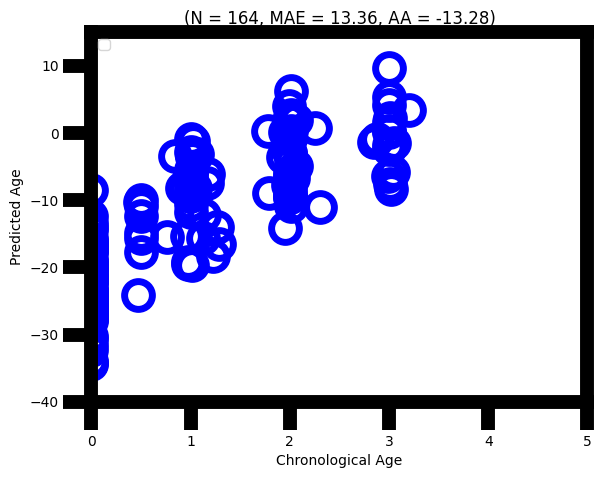

In [71]:
pred = model.predict(df_meth)
mae = np.median(np.abs(pred - df_ann))
age_accel = np.mean((pred - df_ann))
plt.plot(df_ann, pred, 'o', color='blue', mfc='none', markersize=20, markeredgewidth=5)
lin_reg = LinearRegression(fit_intercept=True).fit(df_ann.reshape(-1, 1), pred)
#plt.plot(np.arange(0,100), (np.arange(0,100) * lin_reg.coef_[0]) + lin_reg.intercept_, color='red', label='slope = ' + str(round(lin_reg.coef_[0], 2)), linewidth=10)
#plt.plot(np.arange(0,100), np.arange(0,100), color='blue', label='y=x', linewidth=5)
plt.title('(N = ' + str(len(df_ann)) + ', MAE = ' + str(round(mae,2)) + ', AA = ' + str(round(age_accel,2)) + ')')
plt.xlim(0,5)
plt.ylim(-40,15)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='major', length=20, width=10)
plt.gca().spines['left'].set_linewidth(10) 
plt.gca().spines['bottom'].set_linewidth(10) 
plt.gca().spines['top'].set_linewidth(10) 
plt.gca().spines['right'].set_linewidth(10) 
plt.legend(fontsize=10, loc='upper left')
plt.xlabel("Chronological Age", fontsize=10)
plt.ylabel("Predicted Age", fontsize=10)
plt.show()

In [27]:
def get_cpg_percentages_in_clocks(cpg_list, model_cpg_lists, model_names):
        s = 0
        for list in model_cpg_lists:
                perc = len(set(cpg_list) & set(list)) / len(set(cpg_list))
                print('Percent of cpgs that are in ' + model_names[s] + ': ' + str(perc * 100))
                s = s + 1

In [ ]:
model_names = ['altum', 'grim', 'hannum', 'horvath', 'skin blood', 'pheno']
with open('cpg lists/altum_coeffs_cpg_sites_general.csv', 'r') as file:
    altum_cpgs = set(file.read().splitlines())
with open('cpg lists/grim_coeffs_cpg_sites_general.csv', 'r') as file:
    grim_cpgs = set(file.read().splitlines())
with open('cpg lists/hannum_coeffs_cpg_sites_general.csv', 'r') as file:
    hannum_cpgs = set(file.read().splitlines())
with open('cpg lists/horvath_coeffs_cpg_sites_general.csv', 'r') as file:
    horvath_cpgs = set(file.read().splitlines())
with open('cpg lists/horvath_skin_blood_coeffs_cpg_sites_general.csv', 'r') as file:
    horvath_sb_cpgs = set(file.read().splitlines())
with open('cpg lists/pheno_coeffs_cpg_sites_general.csv', 'r') as file:
    pheno_cpgs = set(file.read().splitlines())

In [28]:
lists = [altum_cpgs, grim_cpgs, hannum_cpgs, horvath_cpgs, horvath_sb_cpgs, pheno_cpgs]
EPIC_cpgs = altum_cpgs | grim_cpgs | hannum_cpgs | horvath_cpgs | horvath_sb_cpgs | pheno_cpgs
EPIC_cpgs = sorted(EPIC_cpgs)
get_cpg_percentages_in_clocks(EPIC_cpgs, lists, model_names)

NameError: name 'altum_cpgs' is not defined

In [ ]:
from itertools import combinations

lists = [altum_cpgs, grim_cpgs, hannum_cpgs, horvath_cpgs, horvath_sb_cpgs, pheno_cpgs]
# Compute common strings in at least two lists
result_list = set()

for combo in combinations(lists, 2):
    result_list.update(set(combo[0]) & set(combo[1]))

EPIC900_cpgs = sorted(result_list)
get_cpg_percentages_in_clocks(EPIC900_cpgs, lists, model_names)

In [ ]:
from itertools import combinations

lists = [altum_cpgs, grim_cpgs, hannum_cpgs, horvath_cpgs, horvath_sb_cpgs, pheno_cpgs]
# Compute common strings in at least two lists
result_list = set()

for combo in combinations(lists, 3):
    result_list.update(set(combo[0]) & set(combo[1]))

EPIC470_cpgs = sorted(result_list)
get_cpg_percentages_in_clocks(EPIC470_cpgs, lists, model_names)

In [ ]:
missing_altum_cpgs = ['cg00149659', 'cg00155167', 'cg00210842', 'cg00214855', 'cg00280814', 'cg00309204', 'cg00398048', 'cg00432979', 'cg00436282', 'cg00461841', 'cg00547018', 'cg00551244', 'cg00630583', 'cg00648153', 'cg00650762', 'cg00659129', 'cg00917893', 'cg01036173', 'cg01139966', 'cg01311051', 'cg01371477', 'cg01381846', 'cg01481441', 'cg01488147', 'cg01491225', 'cg01511567', 'cg01533387', 'cg01578341', 'cg01630869', 'cg01675895', 'cg01725199', 'cg01773854', 'cg01776246', 'cg01808130', 'cg01813965', 'cg01817393', 'cg01889448', 'cg01936270', 'cg01990334', 'cg01994779', 'cg02065387', 'cg02105377', 'cg02121943', 'cg02284889', 'cg02304930', 'cg02309273', 'cg02342494', 'cg02430692', 'cg02475653', 'cg02600515', 'cg02646854', 'cg02655623', 'cg02724472', 'cg02756614', 'cg02757432', 'cg02831393', 'cg02888247', 'cg02904235', 'cg02916816', 'cg03085637', 'cg03102516', 'cg03148461', 'cg03165700', 'cg03221914', 'cg03264414', 'cg03302287', 'cg03382304', 'cg03454353', 'cg03476370', 'cg03600687', 'cg03684977', 'cg03747695', 'cg03750407', 'cg03785807', 'cg03807314', 'cg03909500', 'cg03955296', 'cg04001802', 'cg04033650', 'cg04063348', 'cg04117338', 'cg04121771', 'cg04126427', 'cg04187545', 'cg04219321', 'cg04229238', 'cg04338788', 'cg04368877', 'cg04376617', 'cg04497885', 'cg04599297', 'cg04616566', 'cg04619859', 'cg04705866', 'cg04743872', 'cg04752565', 'cg04762213', 'cg04820387', 'cg04856689', 'cg05087948', 'cg05130485', 'cg05164185', 'cg05168404', 'cg05189291', 'cg05200311', 'cg05205664', 'cg05313261', 'cg05321960', 'cg05380910', 'cg05411032', 'cg05467458', 'cg05473175', 'cg05564251', 'cg05669210', 'cg05726109', 'cg05727959', 'cg05779068', 'cg06007645', 'cg06148175', 'cg06150803', 'cg06151964', 'cg06251129', 'cg06291334', 'cg06321883', 'cg06356454', 'cg06366981', 'cg06386533', 'cg06459327', 'cg06491116', 'cg06506864', 'cg06537230', 'cg06665322', 'cg06718696', 'cg06725035', 'cg06885782', 'cg06995715', 'cg07009002', 'cg07207937', 'cg07274506', 'cg07295034', 'cg07398350', 'cg07414384', 'cg07503829', 'cg07613278', 'cg07707498', 'cg07844021', 'cg07903918', 'cg07928695', 'cg07979752', 'cg08089301', 'cg08126211', 'cg08198370', 'cg08212685', 'cg08228917', 'cg08426384', 'cg08521225', 'cg08576197', 'cg08578305', 'cg08596544', 'cg08661227', 'cg08662074', 'cg08674093', 'cg08724517', 'cg08797194', 'cg08859916', 'cg08927738', 'cg08935003', 'cg09009259', 'cg09087966', 'cg09205751', 'cg09296044', 'cg09338170', 'cg09374949', 'cg09375488', 'cg09386615', 'cg09453737', 'cg09559551', 'cg09638834', 'cg09688763', 'cg09752703', 'cg09868597', 'cg09871315', 'cg09872233', 'cg09929564', 'cg10000775', 'cg10021735', 'cg10025865', 'cg10058540', 'cg10146929', 'cg10247252', 'cg10305797', 'cg10365880', 'cg10367730', 'cg10409680', 'cg10450322', 'cg10453040', 'cg10773869', 'cg10878896', 'cg11114344', 'cg11126134', 'cg11189837', 'cg11337525', 'cg11388238', 'cg11405695', 'cg11484872', 'cg11593656', 'cg11608114', 'cg11654620', 'cg11655691', 'cg11670211', 'cg11781389', 'cg11877382', 'cg11911418', 'cg11913104', 'cg12067287', 'cg12126248', 'cg12187213', 'cg12188416', 'cg12188860', 'cg12274479', 'cg12288726', 'cg12365667', 'cg12368241', 'cg12403575', 'cg12503243', 'cg12513379', 'cg12535715', 'cg12542604', 'cg12556991', 'cg12578480', 'cg12624523', 'cg12627583', 'cg12629325', 'cg12638745', 'cg12643449', 'cg12644353', 'cg12646585', 'cg12696750', 'cg12737574', 'cg12758687', 'cg12830829', 'cg12835684', 'cg12884406', 'cg12914014', 'cg12952136', 'cg12991341', 'cg13058581', 'cg13080465', 'cg13131015', 'cg13234848', 'cg13243219', 'cg13297960', 'cg13326338', 'cg13372488', 'cg13410437', 'cg13633026', 'cg13634678', 'cg13645811', 'cg13654195', 'cg13722123', 'cg13735974', 'cg13877915', 'cg13882835', 'cg14047008', 'cg14091223', 'cg14133708', 'cg14138171', 'cg14149007', 'cg14178895', 'cg14236602', 'cg14318370', 'cg14329157', 'cg14372394', 'cg14423778', 'cg14426525', 'cg14472778', 'cg14545899', 'cg14613972', 'cg14671488', 'cg14700821', 'cg14795305', 'cg14800883', 'cg14802310', 'cg14839932', 'cg14916288', 'cg14927277', 'cg14932684', 'cg14948436', 'cg14981132', 'cg15078479', 'cg15214092', 'cg15269875', 'cg15308737', 'cg15316289', 'cg15329467', 'cg15350455', 'cg15411984', 'cg15481539', 'cg15488251', 'cg15565533', 'cg15572787', 'cg15597540', 'cg15605888', 'cg15673110', 'cg15687659', 'cg15707568', 'cg15727320', 'cg15736336', 'cg15739944', 'cg15747933', 'cg15792688', 'cg15798530', 'cg15824080', 'cg15869022', 'cg15903421', 'cg15977816', 'cg16001460', 'cg16007185', 'cg16094954', 'cg16121444', 'cg16173109', 'cg16185365', 'cg16250754', 'cg16257091', 'cg16280313', 'cg16310717', 'cg16341373', 'cg16361890', 'cg16427670', 'cg16551261', 'cg16592658', 'cg16677885', 'cg16689634', 'cg16721202', 'cg16779976', 'cg16796590', 'cg17133183', 'cg17304433', 'cg17304878', 'cg17352004', 'cg17353431', 'cg17416146', 'cg17543123', 'cg17563769', 'cg17582250', 'cg17607024', 'cg17683775', 'cg17701886', 'cg17729941', 'cg17754980', 'cg17851105', 'cg17890764', 'cg17895873', 'cg17904739', 'cg17920197', 'cg17971003', 'cg17990871', 'cg18003135', 'cg18139900', 'cg18190433', 'cg18202456', 'cg18219226', 'cg18248112', 'cg18292394', 'cg18357645', 'cg18384097', 'cg18392482', 'cg18413900', 'cg18427589', 'cg18587364', 'cg18619831', 'cg18641050', 'cg18704595', 'cg18722841', 'cg18811423', 'cg18953280', 'cg19072037', 'cg19154173', 'cg19167673', 'cg19356324', 'cg19455368', 'cg19595170', 'cg19632760', 'cg19767249', 'cg19831575', 'cg19835478', 'cg19904653', 'cg20011974', 'cg20023578', 'cg20051177', 'cg20139214', 'cg20263942', 'cg20284673', 'cg20287640', 'cg20346096', 'cg20496643', 'cg20525378', 'cg20585500', 'cg20627916', 'cg20728496', 'cg20775254', 'cg20789691', 'cg20795863', 'cg20881910', 'cg20932765', 'cg20969242', 'cg21092324', 'cg21165219', 'cg21206959', 'cg21289015', 'cg21298523', 'cg21504624', 'cg21611708', 'cg21618439', 'cg21642649', 'cg21667943', 'cg21678388', 'cg21712678', 'cg21754343', 'cg21820677', 'cg21922841', 'cg21939482', 'cg21968169', 'cg22021786', 'cg22051763', 'cg22283058', 'cg22295573', 'cg22341104', 'cg22377237', 'cg22464186', 'cg22680204', 'cg22800631', 'cg22814929', 'cg22825487', 'cg22926560', 'cg22995176', 'cg23018448', 'cg23032316', 'cg23036025', 'cg23054676', 'cg23074747', 'cg23114594', 'cg23226134', 'cg23240961', 'cg23274244', 'cg23282674', 'cg23306832', 'cg23337754', 'cg23408913', 'cg23520347', 'cg23632840', 'cg23698058', 'cg23735442', 'cg23792364', 'cg23858360', 'cg23896056', 'cg23957915', 'cg24034289', 'cg24084891', 'cg24088229', 'cg24101359', 'cg24117442', 'cg24176037', 'cg24341129', 'cg24400943', 'cg24445405', 'cg24481633', 'cg24497877', 'cg24532669', 'cg24558204', 'cg24687051', 'cg24735937', 'cg24792272', 'cg24832140', 'cg24903376', 'cg25007680', 'cg25017250', 'cg25098644', 'cg25101056', 'cg25149927', 'cg25172835', 'cg25219134', 'cg25302370', 'cg25418831', 'cg25425078', 'cg25527547', 'cg25598083', 'cg25762395', 'cg25788012', 'cg25802871', 'cg25859012', 'cg25922239', 'cg25956985', 'cg25969212', 'cg25985103', 'cg25990230', 'cg25999267', 'cg26020513', 'cg26045205', 'cg26069745', 'cg26097271', 'cg26199493', 'cg26266098', 'cg26357453', 'cg26530200', 'cg26637901', 'cg26647453', 'cg26665419', 'cg26729026', 'cg26764555', 'cg26767761', 'cg26790132', 'cg26809210', 'cg26820922', 'cg26850754', 'cg27015174', 'cg27091343', 'cg27363310', 'cg27376817', 'cg27398547', 'cg27519373', 'cg27519424', 'cg27566805', 'cg27655905']
missing_horvath_cpgs = ['cg02654291', 'cg02972551', 'cg09785172', 'cg09869858', 'cg13682722', 'cg14329157', 'cg16494477', 'cg17408647', 'cg19167673', 'cg19273182', 'cg19945840', 'cg20795863', 'cg27319898', 'cg01511567', 'cg04431054', 'cg05590257', 'cg06117855', 'cg11388238', 'cg14423778', 'cg19046959', 'cg19569684', 'cg24471894', 'cg27016307']
missing_hannum_cpgs = ['ch.13.39564907R', 'cg14361627', 'cg21139312', 'cg09651136', 'ch.2.30415474F', 'cg18473521', 'cg07927379', 'cg24079702', 'cg25428494']
missing_horvath_sb_cpgs = ['cg07303143', 'cg14614643', 'cg11620135', 'cg01892695', 'cg13767001', 'cg26311454', 'cg06737494', 'cg02901139']
missing_grim_cpgs = list(set(['cg20569940', 'cg26156167', 'cg20800892', 'cg03274876', 'cg17533522', 'cg14868212', 'cg13309828', 'cg03415429', 'cg15947697', 'cg11867651', 'cg07205627', 'cg12211040', 'cg01624571', 'cg08072101', 'cg03400403', 'cg21736089', 'cg03706056'] + ['cg06901711', 'cg24110177', 'cg10177080', 'cg15845365', 'cg02081065', 'cg03807873', 'cg07025011', 'cg02716826', 'cg13898384', 'cg09845806'] + ['cg21789941', 'cg13371627', 'cg00684178', 'cg03900798', 'cg17543884', 'cg15822010', 'cg24493971', 'cg16649728', 'cg05021075', 'cg01641177', 'cg07660627', 'cg23549061'] + ['cg16511983', 'cg01491219', 'cg05515143', 'cg00706683', 'cg19393314', 'cg21770393', 'cg01206872', 'cg14924781', 'cg01704252', 'cg07338119', 'cg19012696', 'cg12465010', 'cg06809342', 'cg04265051', 'cg12051762', 'cg17116694', 'cg25939203', 'cg23047825', 'cg03294557', 'cg27087885', 'cg20448001', 'cg15480287'] + ['cg25149516', 'cg11782409', 'cg07274490', 'cg07929447'] + ['cg04659537', 'cg12791136', 'cg12918464', 'cg00398048', 'cg09578605', 'cg21584251', 'cg04599158', 'cg02627240', 'cg01026009', 'cg03276920', 'cg22355889', 'cg26527903', 'cg13611456', 'cg27294156', 'cg06133392', 'cg23573129', 'cg09219182', 'cg18476633', 'cg26341773', 'cg25034591', 'cg03102848', 'cg18154457', 'cg11924796', 'cg08871010', 'cg06780601', 'cg27395754', 'cg02587153', 'cg15192905', 'cg08352336', 'cg01997410', 'cg16730484', 'cg22686892', 'cg14073590', 'cg07989867', 'cg21080294', 'cg14680768', 'cg10142252', 'cg18717447', 'cg03960747', 'cg16832801'] + ['cg24145109', 'cg08926056', 'cg05971102', 'cg12977946', 'cg06841024', 'cg10407935', 'cg05890887', 'cg12716346', 'cg21227060', 'cg11074353', 'cg07665217', 'cg02505126', 'cg21462914', 'cg19328485', 'cg02580722', 'cg10530344', 'cg21658515', 'cg09351263', 'cg22510362', 'cg00892703', 'cg08667899', 'cg23083672', 'cg02758183', 'cg20308511', 'cg21412053', 'cg26071410', 'cg09625066', 'cg11235848', 'cg02311013', 'cg21664443', 'cg05127178', 'cg19110434', 'cg25697726', 'cg03204600', 'cg11049305', 'cg13501581', 'cg01564693', 'cg10509982', 'cg20557017', 'cg05373692', 'cg05470074', 'cg08262933', 'cg15062055', 'cg12889449', 'cg23955970', 'cg05530348', 'cg11595135', 'cg06298190', 'cg20686207', 'cg14686949', 'cg18003791', 'cg05295197', 'cg23106779'] + ['cg04974804', 'cg12386614', 'cg13678787', 'cg03913456', 'cg24506130', 'cg05308744', 'cg06813250', 'cg07951602', 'cg26816491', 'cg06176987', 'cg22744079', 'cg12599971', 'cg05466385', 'cg26905845', 'cg03730314', 'cg19196326', 'cg17220237', 'cg25977769', 'cg07592681', 'cg14457452', 'cg22660341', 'cg01508796', 'cg17044529', 'cg01802397', 'cg01308343', 'cg15471661', 'cg16558846', 'cg25291250', 'cg02193806', 'cg05815247', 'cg18593194', 'cg22871721', 'cg17215151', 'cg22249566', 'cg17511128', 'cg02495445', 'cg16088894', 'cg13573587', 'cg03788610', 'cg03990195', 'cg08147391', 'cg05548952']))
missing_cpgs = list(set(missing_altum_cpgs + missing_hannum_cpgs + missing_horvath_cpgs + missing_horvath_sb_cpgs + missing_grim_cpgs))

In [ ]:
np.save('GTEX_trainX.npy', xtrain)
np.save('GTEX_trainY.npy', ytrain)
import json
for key, value in testsets.items():
    testsets[key] = tuple(arr.tolist() for arr in value)

with open('GTEX_test.json', 'w') as file:
   json.dump(testsets, file)

In [ ]:
print(data_dict)

EnsembleEPIC

In [ ]:
X_train, Y_train, test_sets = get_datasets(EPIC_cpgs)

In [ ]:
#l1 = Lasso(alpha=0.01, fit_intercept=True).fit(X_train, Y_train)
#joblib.dump(l1, 'regression_weights/L1Regression_EPIC.pkl')
ensembleEPIC = joblib.load('regression_weights/L1Regression_EPIC.pkl')

In [ ]:
plt.hist(ensembleEPIC.coef_, range=(-1,1))

In [ ]:
show_results(ensembleEPIC, test_sets)

EnsembleEPIC900

In [ ]:
X_train, Y_train, test_sets = get_datasets(EPIC900_cpgs)

In [ ]:
#l1 = Lasso(alpha=0.01, fit_intercept=True).fit(X_train, Y_train)
#joblib.dump(l1, 'regression_weights/L1Regression_EPIC900.pkl')
ensembleEPIC900 = joblib.load('regression_weights/L1Regression_EPIC900.pkl')

#l1 = Ridge(alpha=0.01, fit_intercept=False).fit(X_train, Y_train)
#joblib.dump(l1, 'regression_weights/L2Regression_EPIC900.pkl')
#l1 = joblib.load('regression_weights/L2Regression_EPIC900.pkl')

In [ ]:
plt.hist(ensembleEPIC900.coef_, range=(-1,1))

In [ ]:
show_results(ensembleEPIC900, test_sets)

EnsembleEPIC470

In [ ]:
X_train, Y_train, test_sets = get_datasets(EPIC470_cpgs)

In [ ]:
#l1 = Lasso(alpha=0.01, fit_intercept=True).fit(X_train, Y_train)
#joblib.dump(l1, 'regression_weights/L1Regression_EPIC470.pkl')
ensembleEPIC470 = joblib.load('regression_weights/L1Regression_EPIC470.pkl')

#l1 = Ridge(alpha=0.01, fit_intercept=False).fit(X_train, Y_train)
#joblib.dump(l1, 'regression_weights/L2Regression_EPIC470.pkl')
#l1 = joblib.load('regression_weights/L2Regression_EPIC470.pkl')

In [ ]:
plt.hist(ensembleEPIC470.coef_, range=(-1,1))

In [ ]:
show_results(ensembleEPIC470, test_sets)

In [ ]:
_, _, test_sets_21k = get_datasets(EPIC_cpgs)
_, _, test_sets_900 = get_datasets(EPIC900_cpgs)
_, _, test_sets_470 = get_datasets(EPIC470_cpgs)
X_train, Y_train, test_sets_pearson = get_datasets(EPICpearson_cpgs)

In [ ]:
ensembleEPICpearson= Ridge(alpha=0.01, fit_intercept=True).fit(X_train, Y_train)

In [ ]:
joblib.dump(ensembleEPICpearson, 'regression_weights/L2Regression_EPICPearson.pkl')

In [ ]:
fontSize = 100
legendFontSize = 70
tickLabelSize = 60
n = 0
accels = {}
errors = {}
slopes = {}
for organ_type in organs:
        curr_mae = []
        curr_aa = []
        curr_slopes = []
        df = pd.read_table('input/GTEx/GTEx_' + organ_type + '.meth.csv')
        df_grim = pd.read_table('input/GTEx/GTEx_' + organ_type + '.meth.csv')
        missing_rows = [[cpg] + [0.5] * (len(df.columns) - 1) for cpg in missing_cpgs]
        df = pd.concat([df, pd.DataFrame(missing_rows, columns=df.columns)], ignore_index=True)
        df_grim = pd.concat([df_grim, pd.DataFrame([[cpg] + [0.5] * (len(df.columns) - 1) for cpg in missing_grim_cpgs], columns=df_grim.columns)], ignore_index=True)
        real_age, real_gender = get_true_age_labels('input/GTEx/GTEx_' + organ_type + '.anno.csv')
        df_grim = pd.concat([df_grim, pd.DataFrame([['Age'] + list(real_age)], columns=df_grim.columns)], ignore_index=True)
        df_grim = pd.concat([df_grim, pd.DataFrame([['Female'] + list(real_gender)], columns=df_grim.columns)], ignore_index=True)
        
        print('Ensemble Naive')
        pred = np.mean([get_altum_age(df), get_horvath_age(df), get_hannum_age(df), get_pheno_age(df), get_horvath_sb_age(df), get_grim_age(df_grim)], axis=0)
        plt.figure(figsize=(26,26))
        plt.plot(real_age, pred, 'o', color='black', mfc='none', markersize=20, markeredgewidth=5)
        lin_reg = LinearRegression(fit_intercept=True).fit(real_age.reshape((-1, 1)), pred)
        plt.plot(np.arange(0,100), (np.arange(0,100) * lin_reg.coef_[0]) + lin_reg.intercept_, color='red', label='slope = ' + str(round(lin_reg.coef_[0], 2)), linewidth=10)
        plt.plot(np.arange(0,100), np.arange(0,100), color='blue', label='y=x', linewidth=5)
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        plt.tick_params(axis='both', which='major', labelsize=tickLabelSize)
        plt.tick_params(axis='both', which='major', length=20, width=10)
        plt.gca().spines['left'].set_linewidth(10) 
        plt.gca().spines['bottom'].set_linewidth(10) 
        plt.gca().spines['top'].set_linewidth(10) 
        plt.gca().spines['right'].set_linewidth(10) 
        plt.legend(fontsize=legendFontSize, loc='upper left')
        plt.title(organ_type + " (N = " + str(len(real_age)) + ") Ensemble Naive", fontsize=fontSize)
        plt.xlabel("Chronological Age", fontsize=fontSize)
        plt.ylabel("Predicted Age", fontsize=fontSize)
        save_path = 'Graphs/Figure_' + str(n) + '1.png'
        plt.gca().set_aspect('equal', adjustable='box')
        plt.subplots_adjust(top=1)
        plt.savefig(save_path)
        plt.clf()
        curr_mae.append(np.median(np.abs(pred - real_age)))
        curr_aa.append(np.mean((pred - real_age)))
        curr_slopes.append(round(lin_reg.coef_[0], 2))

        print('Ensemble 21k L1')
        pred = joblib.load('regression_weights/L1Regression_EPIC.pkl').predict(test_sets_21k[n][0])
        plt.figure(figsize=(26,26))
        plt.plot(test_sets_21k[n][1], pred, 'o', color='black', mfc='none', markersize=20, markeredgewidth=5)
        lin_reg = LinearRegression(fit_intercept=True).fit(test_sets_21k[n][1].reshape((-1, 1)), pred)
        plt.plot(np.arange(0,100), (np.arange(0,100) * lin_reg.coef_[0]) + lin_reg.intercept_, color='red', label='slope = ' + str(round(lin_reg.coef_[0], 2)), linewidth=10)
        plt.plot(np.arange(0,100), np.arange(0,100), color='blue', label='y=x', linewidth=5)
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        plt.tick_params(axis='both', which='major', labelsize=tickLabelSize)
        plt.tick_params(axis='both', which='major', length=20, width=10)
        plt.gca().spines['left'].set_linewidth(10) 
        plt.gca().spines['bottom'].set_linewidth(10) 
        plt.gca().spines['top'].set_linewidth(10) 
        plt.gca().spines['right'].set_linewidth(10) 
        plt.legend(fontsize=legendFontSize, loc='upper left')
        plt.title(organ_type + " (N = " + str(len(test_sets_21k[n][1])) + ") Ensemble 21k L1", fontsize=fontSize)
        plt.xlabel("Chronological Age", fontsize=fontSize)
        plt.ylabel("Predicted Age", fontsize=fontSize)
        save_path = 'Graphs/Figure_' + str(n) + '2.png'
        plt.gca().set_aspect('equal', adjustable='box')
        plt.subplots_adjust(top=1)
        plt.savefig(save_path)
        plt.clf()
        curr_mae.append(np.median(np.abs(pred - test_sets_21k[n][1])))
        curr_aa.append(np.mean((pred - test_sets_21k[n][1])))
        curr_slopes.append(round(lin_reg.coef_[0], 2))

        print('Ensemble 900 L1')
        pred = joblib.load('regression_weights/L1Regression_EPIC900.pkl').predict(test_sets_900[n][0])
        plt.figure(figsize=(26,26))
        plt.plot(test_sets_900[n][1], pred, 'o', color='black', mfc='none', markersize=20, markeredgewidth=5)
        lin_reg = LinearRegression(fit_intercept=True).fit(test_sets_900[n][1].reshape((-1, 1)), pred)
        plt.plot(np.arange(0,100), (np.arange(0,100) * lin_reg.coef_[0]) + lin_reg.intercept_, color='red', label='slope = ' + str(round(lin_reg.coef_[0], 2)), linewidth=10)
        plt.plot(np.arange(0,100), np.arange(0,100), color='blue', label='y=x', linewidth=5)
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        plt.tick_params(axis='both', which='major', labelsize=tickLabelSize)
        plt.tick_params(axis='both', which='major', length=20, width=10)
        plt.gca().spines['left'].set_linewidth(10) 
        plt.gca().spines['bottom'].set_linewidth(10) 
        plt.gca().spines['top'].set_linewidth(10) 
        plt.gca().spines['right'].set_linewidth(10) 
        plt.legend(fontsize=legendFontSize, loc='upper left')
        plt.title(organ_type + " (N = " + str(len(test_sets_900[n][1])) + ") Ensemble 900 L1", fontsize=fontSize)
        plt.xlabel("Chronological Age", fontsize=fontSize)
        plt.ylabel("Predicted Age", fontsize=fontSize)
        save_path = 'Graphs/Figure_' + str(n) + '3.png'
        plt.gca().set_aspect('equal', adjustable='box')
        plt.subplots_adjust(top=1)
        plt.savefig(save_path)
        plt.clf()
        curr_mae.append(np.median(np.abs(pred - test_sets_900[n][1])))
        curr_aa.append(np.mean((pred - test_sets_900[n][1])))
        curr_slopes.append(round(lin_reg.coef_[0], 2))

        print('Ensemble 470 L1')
        pred = joblib.load('regression_weights/L1Regression_EPIC470.pkl').predict(test_sets_470[n][0])
        plt.figure(figsize=(26,26))
        plt.plot(test_sets_470[n][1], pred, 'o', color='black', mfc='none', markersize=20, markeredgewidth=5)
        lin_reg = LinearRegression(fit_intercept=True).fit(test_sets_470[n][1].reshape((-1, 1)), pred)
        plt.plot(np.arange(0,100), (np.arange(0,100) * lin_reg.coef_[0]) + lin_reg.intercept_, color='red', label='slope = ' + str(round(lin_reg.coef_[0], 2)), linewidth=10)
        plt.plot(np.arange(0,100), np.arange(0,100), color='blue', label='y=x', linewidth=5)
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        plt.tick_params(axis='both', which='major', labelsize=tickLabelSize)
        plt.tick_params(axis='both', which='major', length=20, width=10)
        plt.gca().spines['left'].set_linewidth(10) 
        plt.gca().spines['bottom'].set_linewidth(10) 
        plt.gca().spines['top'].set_linewidth(10) 
        plt.gca().spines['right'].set_linewidth(10) 
        plt.legend(fontsize=legendFontSize, loc='upper left')
        plt.title(organ_type + " (N = " + str(len(test_sets_470[n][1])) + ") Ensemble 470 L1", fontsize=fontSize)
        plt.xlabel("Chronological Age", fontsize=fontSize)
        plt.ylabel("Predicted Age", fontsize=fontSize)
        save_path = 'Graphs/Figure_' + str(n) + '4.png'
        plt.gca().set_aspect('equal', adjustable='box')
        plt.subplots_adjust(top=1)
        plt.savefig(save_path)
        plt.clf()
        curr_mae.append(np.median(np.abs(pred - test_sets_470[n][1])))
        curr_aa.append(np.mean((pred - test_sets_470[n][1])))
        curr_slopes.append(round(lin_reg.coef_[0], 2))

        print('Ensemble 470 L2')
        pred = joblib.load('regression_weights/L2Regression_EPIC470.pkl').predict(test_sets_470[n][0])
        plt.figure(figsize=(26,26))
        plt.plot(test_sets_470[n][1], pred, 'o', color='black', mfc='none', markersize=20, markeredgewidth=5)
        lin_reg = LinearRegression(fit_intercept=True).fit(test_sets_470[n][1].reshape((-1, 1)), pred)
        plt.plot(np.arange(0,100), (np.arange(0,100) * lin_reg.coef_[0]) + lin_reg.intercept_, color='red', label='slope = ' + str(round(lin_reg.coef_[0], 2)), linewidth=10)
        plt.plot(np.arange(0,100), np.arange(0,100), color='blue', label='y=x', linewidth=5)
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        plt.tick_params(axis='both', which='major', labelsize=tickLabelSize)
        plt.tick_params(axis='both', which='major', length=20, width=10)
        plt.gca().spines['left'].set_linewidth(10) 
        plt.gca().spines['bottom'].set_linewidth(10) 
        plt.gca().spines['top'].set_linewidth(10) 
        plt.gca().spines['right'].set_linewidth(10) 
        plt.legend(fontsize=legendFontSize, loc='upper left')
        plt.title(organ_type + " (N = " + str(len(test_sets_470[n][1])) + ") Ensemble 470 L2", fontsize=fontSize)
        plt.xlabel("Chronological Age", fontsize=fontSize)
        plt.ylabel("Predicted Age", fontsize=fontSize)
        save_path = 'Graphs/Figure_' + str(n) + '5.png'
        plt.gca().set_aspect('equal', adjustable='box')
        plt.subplots_adjust(top=1)
        plt.savefig(save_path)
        plt.clf()
        curr_mae.append(np.median(np.abs(pred - test_sets_470[n][1])))
        curr_aa.append(np.mean((pred - test_sets_470[n][1])))
        curr_slopes.append(round(lin_reg.coef_[0], 2))

        print('Ensemble Pearson Model')
        pred = ensembleEPICpearson.predict(test_sets_pearson[n][0])
        plt.figure(figsize=(26,26))
        plt.plot(test_sets_pearson[n][1], pred, 'o', color='black', mfc='none', markersize=20, markeredgewidth=5)
        lin_reg = LinearRegression(fit_intercept=True).fit(test_sets_pearson[n][1].reshape((-1, 1)), pred)
        plt.plot(np.arange(0,100), (np.arange(0,100) * lin_reg.coef_[0]) + lin_reg.intercept_, color='red', label='slope = ' + str(round(lin_reg.coef_[0], 2)), linewidth=10)
        plt.plot(np.arange(0,100), np.arange(0,100), color='blue', label='y=x', linewidth=5)
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        plt.tick_params(axis='both', which='major', labelsize=tickLabelSize)
        plt.tick_params(axis='both', which='major', length=20, width=10)
        plt.gca().spines['left'].set_linewidth(10) 
        plt.gca().spines['bottom'].set_linewidth(10) 
        plt.gca().spines['top'].set_linewidth(10) 
        plt.gca().spines['right'].set_linewidth(10) 
        plt.legend(fontsize=legendFontSize, loc='upper left')
        plt.title(organ_type + " (N = " + str(len(test_sets_pearson[n][1])) + ") Ensemble Pearson L2", fontsize=fontSize)
        plt.xlabel("Chronological Age", fontsize=fontSize)
        plt.ylabel("Predicted Age", fontsize=fontSize)
        save_path = 'Graphs/Figure_' + str(n) + '6.png'
        plt.gca().set_aspect('equal', adjustable='box')
        plt.subplots_adjust(top=1)
        plt.savefig(save_path)
        plt.clf()
        curr_mae.append(np.median(np.abs(pred - test_sets_pearson[n][1])))
        curr_aa.append(np.mean((pred - test_sets_pearson[n][1])))
        curr_slopes.append(round(lin_reg.coef_[0], 2))

        errors[organ_type] = curr_mae
        accels[organ_type] = curr_aa
        slopes[organ_type] = curr_slopes
        n = n + 1
print(errors)
print(accels)

In [ ]:
def dict_of_lists_to_2d_list(dictionary):
    # Get the values from the dictionary
    lists = list(dictionary.values())

    # Find the maximum length of any list in the dictionary
    max_length = max(len(lst) for lst in lists)

    # Create a 2D list with None as a placeholder for missing values
    result = [[None] * max_length for _ in range(len(lists))]

    # Fill in the values from the dictionary
    for i, lst in enumerate(lists):
        result[i][:len(lst)] = lst

    return result

def create_dataframe(data, rows, columns):
    df = pd.DataFrame(data, index=rows, columns=columns)
    return df

slopes_df = create_dataframe(dict_of_lists_to_2d_list(slopes), , )
mae_df = create_dataframe(dict_of_lists_to_2d_list(errors), , )
aa_df = create_dataframe(dict_of_lists_to_2d_list(accels), , )

In [ ]:
# Resize images to a consistent size (optional)
resize_width = 2600
resize_height = 2600


# Create a new image with the grid layout
grid_width = 6
grid_height = 9
grid_image_width = grid_width * resize_width
grid_image_height = grid_height * resize_height
grid_image = Image.new('RGB', (grid_image_width, grid_image_height))

# Set the images in each subplot
for i in range(0,9):
    for j in range(1,7):
        path = 'Graphs/Figure_' + str(i) + str(j) + '.png'
        grid_image.paste(Image.open(path), ((j - 1) * resize_width, i * resize_height))
grid_image.save('grid_image.jpg')

In [ ]:
errors = {'Blood': [3.1902291689176447, 3.3059021443694263, 3.6475627141710447, 3.8941892304324597, 4.724359443758118], 'Breast': [8.237099532189195, 3.343654424635389, 3.5418178794785007, 3.3347556601528723, 3.7431760660891342], 'Colon': [6.712258781700797, 4.388278695422812, 3.624027526655155, 4.019259794817856, 4.6716306684348226], 'Kidney': [10.456722212420829, 3.172162081821149, 1.8078373000216992, 1.4713088238352015, 2.89167077008171], 'Lung': [8.32913002338693, 3.4137010167879254, 4.469695600707993, 4.567031214024944, 3.12489062260984], 'Muscle': [25.528738617597334, 4.067805935361385, 3.5107396974364704, 4.373982392635192, 6.201655727439903], 'Ovary': [31.629721598948837, 4.098589350622191, 4.066679978204455, 4.907958305528815, 5.317237749771827], 'Prostate': [14.45670330790707, 3.7288087330797595, 3.494434456022603, 4.265567817414748, 3.6948774906454815], 'Testis': [29.915152323057228, 6.00903771253417, 4.714350148951517, 3.591502870647094, 4.023328120882255]}
accels = {'Blood': [-0.5244471853803816, -0.27876765201304854, 1.6047480682122135, 1.1675381294997378, 0.7814086633426256], 'Breast': [-8.678393102267293, -1.45321487963057, -5.1973512626800185, -5.665537206970833, -4.4535297767527755], 'Colon': [-5.082829791493533, -1.2655562604781503, -0.7270558513134694, -1.127722784182483, -2.300345765417525], 'Kidney': [-9.774729885105572, 1.6846675029775668, 0.5910875071569819, 0.6596935470102607, 0.6593651088360971], 'Lung': [-8.327966035073093, 0.027027265939299067, -0.4028702893730277, -0.2700601585704208, 0.2066651525573204], 'Muscle': [-25.458330548666908, 1.0817979682130514, 1.9069857889736959, 2.0706593371110515, 3.5133755025328433], 'Ovary': [-29.550575375649615, -0.6413409143502291, 0.10189540745026815, -0.22958830158479965, 0.39866338015154756], 'Prostate': [-14.078356511044312, -2.096535664402184, -2.269027544789228, -3.274597879816121, -2.458956042166312], 'Testis': [-29.9464763373384, -5.549734709267472, -4.86958908439152, -4.348822249280798, -5.651229171879116]}